# 04 — WorldPop (Population)

Create an AOI-clipped population raster (India + Bangladesh) from WorldPop and save a quick diagnostic figure.

## 1. Import

Imports libraries, paths and bounding box

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ceam_config import BBOX, PATHS

import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile

from shapely.geometry import box, mapping
from pyproj import Transformer

# WorldPop files (from config)
fp_ind = PATHS["worldpop_ind_raw"]
fp_bgd = PATHS["worldpop_bgd_raw"]


## 2. Load and mosaic WorldPop tiles

Verify that the India and Bangladesh WorldPop rasters exist, then open and merge them into a single population mosaic. Capture CRS, nodata value, and shape for validation.

In [3]:
for p in [fp_ind, fp_bgd]:
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p.resolve()}")

with rasterio.open(fp_ind) as src1, rasterio.open(fp_bgd) as src2:
    # Mosaic
    mosaic, mosaic_transform = merge([src1, src2])
    mosaic_crs = src1.crs
    mosaic_nodata = src1.nodata

print("Mosaic CRS:", mosaic_crs)
print("Mosaic shape (bands, rows, cols):", mosaic.shape)
print("Mosaic nodata:", mosaic_nodata)


Mosaic CRS: EPSG:4326
Mosaic shape (bands, rows, cols): (1, 3451, 3508)
Mosaic nodata: -99999.0


## 3. Define AOI from configuration

Construct the CEAM Area of Interest (AOI) polygon from the `BBOX` parameters defined in the project configuration (EPSG:4326).

In [4]:
# AOI polygon in EPSG:4326
bbox = BBOX # from config
aoi_4326 = box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])

# Reproject AOI polygon to raster CRS if needed
if mosaic_crs.to_epsg() != 4326:
    t = Transformer.from_crs("EPSG:4326", mosaic_crs, always_xy=True)
    x0, y0 = t.transform(bbox["lon_min"], bbox["lat_min"])
    x1, y1 = t.transform(bbox["lon_max"], bbox["lat_max"])
    aoi = box(min(x0, x1), min(y0, y1), max(x0, x1), max(y0, y1))
else:
    aoi = aoi_4326

aoi_geojson = [mapping(aoi)]



Clipped pop shape: (121, 171)
Clipped transform: | 0.01, 0.00, 88.50|
| 0.00,-0.01, 22.51|
| 0.00, 0.00, 1.00|


## 4. Clip mosaic to AOI

Mask the merged WorldPop raster using the AOI polygon and retain only population values within the CEAM study region.

In [ ]:
# Write mosaic to an in-memory GTiff so we can use rasterio.mask cleanly
meta = {
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "count": mosaic.shape[0],
    "dtype": mosaic.dtype,
    "crs": mosaic_crs,
    "transform": mosaic_transform,
    "nodata": mosaic_nodata,
}

with MemoryFile() as memfile:
    with memfile.open(**meta) as tmp:
        tmp.write(mosaic)
        pop_clip, pop_transform = mask(tmp, aoi_geojson, crop=True)

pop = pop_clip[0]
print("Clipped pop shape:", pop.shape)
print("Clipped transform:", pop_transform)


## 5. Quick visual check (log scale)

Convert nodata values to NaN and render a log-scaled preview of the clipped population raster to verify spatial coverage and intensity patterns.

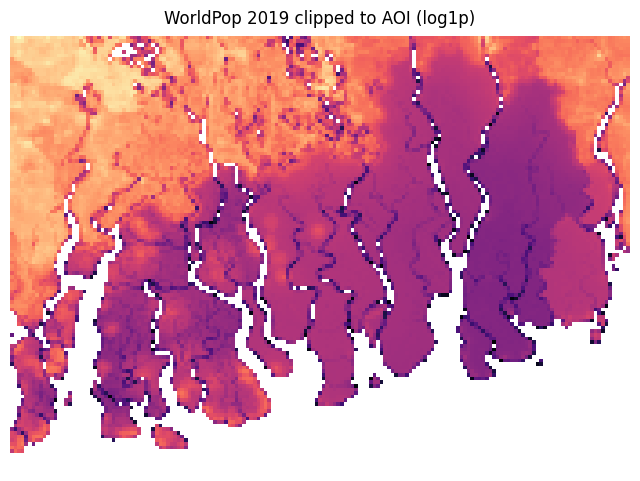

In [5]:
pop_plot = pop.astype("float32")
if mosaic_nodata is not None:
    pop_plot = np.where(pop_plot == mosaic_nodata, np.nan, pop_plot)

plt.figure(figsize=(8, 6))
plt.imshow(np.log1p(pop_plot), cmap="magma")
plt.title("WorldPop 2019 clipped to AOI (log1p)")
plt.axis("off")
plt.show()


## 6. Population statistics and scaled visualization

Compute summary statistics (median and percentiles) for people-per-pixel (PPP) values and render a color-scaled map capped at the 99th percentile for readability.

People-per-pixel stats (PPP, clipped AOI):
  min=0.281  median=75.932  p90=870.560  p95=1236.089  p99=2069.613  max=3851.113


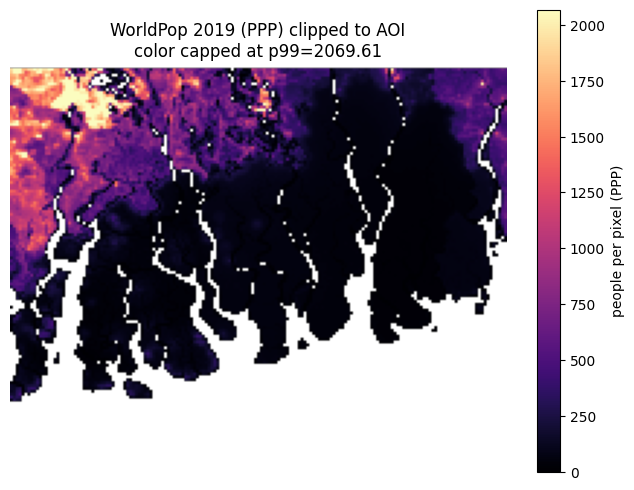

In [6]:
import numpy as np
import matplotlib.pyplot as plt

pop_plot = pop.astype("float32")
if mosaic_nodata is not None:
    pop_plot = np.where(pop_plot == mosaic_nodata, np.nan, pop_plot)

valid = pop_plot[np.isfinite(pop_plot)]
p50, p90, p95, p99 = np.percentile(valid, [50, 90, 95, 99])
vmax = p99  # cap for readability

print(f"People-per-pixel stats (PPP, clipped AOI):")
print(f"  min={np.nanmin(pop_plot):.3f}  median={p50:.3f}  p90={p90:.3f}  p95={p95:.3f}  p99={p99:.3f}  max={np.nanmax(pop_plot):.3f}")

plt.figure(figsize=(8, 6))
im = plt.imshow(pop_plot, cmap="magma", vmin=0, vmax=vmax)
plt.title(f"WorldPop 2019 (PPP) clipped to AOI\ncolor capped at p99={vmax:.2f}")
plt.axis("off")
cb = plt.colorbar(im)
cb.set_label("people per pixel (PPP)")

Path(PATHS["fig_worldpop_clip"]).parent.mkdir(parents=True, exist_ok=True)

plt.savefig(
    PATHS["fig_worldpop_clip"],
    dpi=300,
    bbox_inches="tight"
)

plt.show()
